# Analog test of Probabilistic Model on Target Series

In [36]:
from darts import TimeSeries
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from darts.models import GaussianProcessFilter
from darts import TimeSeries
from sklearn.gaussian_process.kernels import RBF
from darts.models import BlockRNNModel
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import Scaler
from darts.metrics import smape
import numpy as np
import ray
import os
import optuna
from darts.models import TCNModel
from utils_ import make_stitched_series

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
df = pd.read_csv("aquatics-ARIK-oxygen-Predicted.csv")

In [7]:
df.columns[1:]

Index(['.pred', 'oxygen', 'air_temperature',
       'surface_downwelling_longwave_flux_in_air',
       'surface_downwelling_shortwave_flux_in_air', 'precipitation_flux',
       'air_pressure', 'relative_humidity', 'northward_wind', 'eastward_wind'],
      dtype='object')

Preprocessing time series here, again as per usual, I need to fill in gaps.

In [10]:
times = pd.to_datetime(df["datetime"])
times = pd.DatetimeIndex(times)
variables_series_dict = {var: TimeSeries.from_times_and_values(times, 
                                                               df[var], 
                                                               fill_missing_dates=True,
                                                               freq="D") 
                                                for var in df.columns[1:]}

In [12]:
stitched_series_dict = {var: make_stitched_series.remote(variables_series_dict[var]) 
                                            for var in variables_series_dict.keys()}

2023-06-22 19:28:57,104	INFO worker.py:1636 -- Started a local Ray instance.
(make_stitched_series pid=1812873) /home/rstudio/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
(make_stitched_series pid=1812873)   warnings.warn(
(make_stitched_series pid=1812873) /home/rstudio/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
(make_stitched_series pid=1812873)   warnings.warn(
(make_stitched_series pid=1812873) You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all s

In [13]:
stitched_series = {var: ray.get(stitched_series_dict[var]) for var in stitched_series_dict.keys()}

Preprocessing covariates

In [32]:
list(stitched_series.keys())[2:]

['air_temperature',
 'surface_downwelling_longwave_flux_in_air',
 'surface_downwelling_shortwave_flux_in_air',
 'precipitation_flux',
 'air_pressure',
 'relative_humidity',
 'northward_wind',
 'eastward_wind']

Now putting them into format that Darts will accept.

In [29]:
inputs = stitched_series["oxygen"]
stitched_series_keys = list(stitched_series.keys())
covs = stitched_series["air_temperature"]
for index, var in enumerate(stitched_series_keys[3:]):
    covs = covs.concatenate(stitched_series[var], axis=1, ignore_time_axis=True)

Cutting off training and validation set well before plot dates.

In [33]:
# Splitting into training and validations
val_split = pd.Timestamp(year=2023, month=5, day=1)
training_set, validation_set = inputs.split_before(val_split)

Now, doing tuning with optuna.

In [34]:
from optuna.integration import PyTorchLightningPruningCallback
def objective(trial):
    callback = [PyTorchLightningPruningCallback(trial, monitor="val_loss")]

    # Hyperparameters
    input_chunk_length = trial.suggest_categorical("input_chunk_length", [31, 60, 180, 356])
    kernel_size = trial.suggest_categorical("kernel_size", [2, 3, 5])
    num_filters = trial.suggest_categorical("num_filters", [1, 3, 5])
    num_layers = trial.suggest_categorical("num_layers", [None, 1, 2, 3])
    dilation_base = trial.suggest_categorical("dilation_base", [1, 2, 3])
    dropout = trial.suggest_categorical("dropout", [0.1, 0.2, 0.3])

    tcn_model = TCNModel(input_chunk_length=input_chunk_length,
                    kernel_size=kernel_size,
                    num_filters=num_filters,
                    output_chunk_length=30,
                    likelihood=QuantileRegression([0.05, 0.1, 0.5, 0.9, 0.95]))

    tcn_model.fit(training_set,
                  past_covariates=covs,
                  epochs=400, 
                  verbose=False)

    predictions = tcn_model.predict(n=len(validation_set[:30]), 
                                    past_covariates=covs, 
                                    num_samples=50)
    smapes = smape(validation_set[:30], predictions, n_jobs=-1, verbose=False)
    smape_val = np.mean(smapes)

    return smape_val if smape_val != np.nan else float("inf")

In [37]:
def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")


study = optuna.create_study(direction="minimize")

study.optimize(objective, n_trials=100, callbacks=[print_callback])

# We could also have used a command as follows to limit the number of trials instead:
# study.optimize(objective, n_trials=100, callbacks=[print_callback])

# Finally, print the best value and best hyperparameters:
print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

[I 2023-06-22 19:51:08,738] A new study created in memory with name: no-name-0b9e3859-57f4-4eab-bd1b-9c6d79585591
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 19:52:21,861] Trial 0 finished with value: 75.95267839741437 and parameters: {'input_chunk_length': 31, 'kernel_size': 5, 'num_filters': 3, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}. Best is trial 0 with value: 75.95267839741437.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 75.95267839741437, Current params: {'input_chunk_length': 31, 'kernel_size': 5, 'num_filters': 3, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}
Best value: 75.95267839741437, Best params: {'input_chunk_length': 31, 'kernel_size': 5, 'num_filters': 3, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}


(raylet) [2023-06-22 19:52:57,040 E 1812600 1812600] (raylet) node_manager.cc:3069: 2 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: a5fa23da60e5fe6df640ecbfce7fc6de242a88f6d1beaa1d7e455a5c, IP: 172.18.0.16) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.18.0.16`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using

Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 19:53:36,248] Trial 1 finished with value: 33.05616383282016 and parameters: {'input_chunk_length': 60, 'kernel_size': 2, 'num_filters': 3, 'num_layers': 1, 'dilation_base': 3, 'dropout': 0.1}. Best is trial 1 with value: 33.05616383282016.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 33.05616383282016, Current params: {'input_chunk_length': 60, 'kernel_size': 2, 'num_filters': 3, 'num_layers': 1, 'dilation_base': 3, 'dropout': 0.1}
Best value: 33.05616383282016, Best params: {'input_chunk_length': 60, 'kernel_size': 2, 'num_filters': 3, 'num_layers': 1, 'dilation_base': 3, 'dropout': 0.1}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 19:54:48,988] Trial 2 finished with value: 37.64220828862704 and parameters: {'input_chunk_length': 31, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 2, 'dilation_base': 3, 'dropout': 0.2}. Best is trial 1 with value: 33.05616383282016.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 37.64220828862704, Current params: {'input_chunk_length': 31, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 2, 'dilation_base': 3, 'dropout': 0.2}
Best value: 33.05616383282016, Best params: {'input_chunk_length': 60, 'kernel_size': 2, 'num_filters': 3, 'num_layers': 1, 'dilation_base': 3, 'dropout': 0.1}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 19:55:56,699] Trial 3 finished with value: 36.92638617031119 and parameters: {'input_chunk_length': 31, 'kernel_size': 5, 'num_filters': 3, 'num_layers': 1, 'dilation_base': 1, 'dropout': 0.1}. Best is trial 1 with value: 33.05616383282016.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 36.92638617031119, Current params: {'input_chunk_length': 31, 'kernel_size': 5, 'num_filters': 3, 'num_layers': 1, 'dilation_base': 1, 'dropout': 0.1}
Best value: 33.05616383282016, Best params: {'input_chunk_length': 60, 'kernel_size': 2, 'num_filters': 3, 'num_layers': 1, 'dilation_base': 3, 'dropout': 0.1}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 19:57:27,379] Trial 4 finished with value: 17.31843500846497 and parameters: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}. Best is trial 4 with value: 17.31843500846497.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 17.31843500846497, Current params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}
Best value: 17.31843500846497, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 19:58:49,918] Trial 5 finished with value: 17.658206243110904 and parameters: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 1, 'dropout': 0.1}. Best is trial 4 with value: 17.31843500846497.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 17.658206243110904, Current params: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 1, 'dropout': 0.1}
Best value: 17.31843500846497, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:00:00,507] Trial 6 finished with value: 183.89223187233438 and parameters: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 5, 'num_layers': 2, 'dilation_base': 3, 'dropout': 0.3}. Best is trial 4 with value: 17.31843500846497.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 183.89223187233438, Current params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 5, 'num_layers': 2, 'dilation_base': 3, 'dropout': 0.3}
Best value: 17.31843500846497, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:01:20,550] Trial 7 finished with value: 80.81015702754273 and parameters: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 5, 'num_layers': 1, 'dilation_base': 2, 'dropout': 0.2}. Best is trial 4 with value: 17.31843500846497.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 80.81015702754273, Current params: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 5, 'num_layers': 1, 'dilation_base': 2, 'dropout': 0.2}
Best value: 17.31843500846497, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:02:40,548] Trial 8 finished with value: 33.384216920338666 and parameters: {'input_chunk_length': 356, 'kernel_size': 2, 'num_filters': 5, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.1}. Best is trial 4 with value: 17.31843500846497.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 33.384216920338666, Current params: {'input_chunk_length': 356, 'kernel_size': 2, 'num_filters': 5, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.1}
Best value: 17.31843500846497, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:03:58,786] Trial 9 finished with value: 19.617059828266896 and parameters: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 3, 'num_layers': 3, 'dilation_base': 3, 'dropout': 0.1}. Best is trial 4 with value: 17.31843500846497.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 19.617059828266896, Current params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 3, 'num_layers': 3, 'dilation_base': 3, 'dropout': 0.1}
Best value: 17.31843500846497, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:05:12,597] Trial 10 finished with value: 19.900331646670182 and parameters: {'input_chunk_length': 356, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}. Best is trial 4 with value: 17.31843500846497.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 19.900331646670182, Current params: {'input_chunk_length': 356, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}
Best value: 17.31843500846497, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:06:34,717] Trial 11 finished with value: 15.865319960854945 and parameters: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 1, 'dropout': 0.3}. Best is trial 11 with value: 15.865319960854945.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 15.865319960854945, Current params: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 1, 'dropout': 0.3}
Best value: 15.865319960854945, Best params: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 1, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:07:58,563] Trial 12 finished with value: 21.267946060364924 and parameters: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 1, 'dropout': 0.3}. Best is trial 11 with value: 15.865319960854945.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 21.267946060364924, Current params: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 1, 'dropout': 0.3}
Best value: 15.865319960854945, Best params: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 1, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:09:17,328] Trial 13 finished with value: 26.365431745801537 and parameters: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 1, 'dropout': 0.3}. Best is trial 11 with value: 15.865319960854945.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 26.365431745801537, Current params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 1, 'dropout': 0.3}
Best value: 15.865319960854945, Best params: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 1, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:10:28,756] Trial 14 finished with value: 25.47570346904216 and parameters: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 1, 'dropout': 0.3}. Best is trial 11 with value: 15.865319960854945.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 25.47570346904216, Current params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 1, 'dropout': 0.3}
Best value: 15.865319960854945, Best params: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 1, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:11:50,966] Trial 15 finished with value: 21.84491071338315 and parameters: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}. Best is trial 11 with value: 15.865319960854945.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 21.84491071338315, Current params: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}
Best value: 15.865319960854945, Best params: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 1, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:13:19,177] Trial 16 finished with value: 16.494837188465404 and parameters: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}. Best is trial 11 with value: 15.865319960854945.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 16.494837188465404, Current params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}
Best value: 15.865319960854945, Best params: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 1, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:14:33,059] Trial 17 finished with value: 13.014028541091086 and parameters: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}. Best is trial 17 with value: 13.014028541091086.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 13.014028541091086, Current params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}
Best value: 13.014028541091086, Best params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:15:53,580] Trial 18 finished with value: 26.292425732783908 and parameters: {'input_chunk_length': 60, 'kernel_size': 2, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}. Best is trial 17 with value: 13.014028541091086.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 26.292425732783908, Current params: {'input_chunk_length': 60, 'kernel_size': 2, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}
Best value: 13.014028541091086, Best params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:17:09,367] Trial 19 finished with value: 171.40973143393117 and parameters: {'input_chunk_length': 60, 'kernel_size': 5, 'num_filters': 5, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}. Best is trial 17 with value: 13.014028541091086.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 171.40973143393117, Current params: {'input_chunk_length': 60, 'kernel_size': 5, 'num_filters': 5, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}
Best value: 13.014028541091086, Best params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:18:34,732] Trial 20 finished with value: 28.703632594723157 and parameters: {'input_chunk_length': 60, 'kernel_size': 2, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.2}. Best is trial 17 with value: 13.014028541091086.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 28.703632594723157, Current params: {'input_chunk_length': 60, 'kernel_size': 2, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.2}
Best value: 13.014028541091086, Best params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:19:50,278] Trial 21 finished with value: 23.293637637790088 and parameters: {'input_chunk_length': 356, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 2, 'dilation_base': 1, 'dropout': 0.3}. Best is trial 17 with value: 13.014028541091086.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 23.293637637790088, Current params: {'input_chunk_length': 356, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 2, 'dilation_base': 1, 'dropout': 0.3}
Best value: 13.014028541091086, Best params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:21:01,931] Trial 22 finished with value: 39.96028704370749 and parameters: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}. Best is trial 17 with value: 13.014028541091086.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 39.96028704370749, Current params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}
Best value: 13.014028541091086, Best params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:22:18,522] Trial 23 finished with value: 22.372053737653967 and parameters: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}. Best is trial 17 with value: 13.014028541091086.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 22.372053737653967, Current params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}
Best value: 13.014028541091086, Best params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:23:41,331] Trial 24 finished with value: 26.781348442870538 and parameters: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 1, 'dropout': 0.3}. Best is trial 17 with value: 13.014028541091086.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 26.781348442870538, Current params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 1, 'dropout': 0.3}
Best value: 13.014028541091086, Best params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:24:52,337] Trial 25 finished with value: 17.011243243995004 and parameters: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.3}. Best is trial 17 with value: 13.014028541091086.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 17.011243243995004, Current params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.3}
Best value: 13.014028541091086, Best params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:26:05,837] Trial 26 finished with value: 21.25498188751555 and parameters: {'input_chunk_length': 356, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 1, 'dilation_base': 1, 'dropout': 0.3}. Best is trial 17 with value: 13.014028541091086.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 21.25498188751555, Current params: {'input_chunk_length': 356, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 1, 'dilation_base': 1, 'dropout': 0.3}
Best value: 13.014028541091086, Best params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:27:19,795] Trial 27 finished with value: 36.60207123128841 and parameters: {'input_chunk_length': 31, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 2, 'dilation_base': 1, 'dropout': 0.3}. Best is trial 17 with value: 13.014028541091086.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 36.60207123128841, Current params: {'input_chunk_length': 31, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 2, 'dilation_base': 1, 'dropout': 0.3}
Best value: 13.014028541091086, Best params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:28:34,919] Trial 28 finished with value: 85.63409662821499 and parameters: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 5, 'num_layers': 3, 'dilation_base': 3, 'dropout': 0.2}. Best is trial 17 with value: 13.014028541091086.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 85.63409662821499, Current params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 5, 'num_layers': 3, 'dilation_base': 3, 'dropout': 0.2}
Best value: 13.014028541091086, Best params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:29:56,350] Trial 29 finished with value: 85.526833019571 and parameters: {'input_chunk_length': 31, 'kernel_size': 2, 'num_filters': 3, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.3}. Best is trial 17 with value: 13.014028541091086.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 85.526833019571, Current params: {'input_chunk_length': 31, 'kernel_size': 2, 'num_filters': 3, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.3}
Best value: 13.014028541091086, Best params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:31:12,069] Trial 30 finished with value: 200.0 and parameters: {'input_chunk_length': 60, 'kernel_size': 5, 'num_filters': 3, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}. Best is trial 17 with value: 13.014028541091086.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 200.0, Current params: {'input_chunk_length': 60, 'kernel_size': 5, 'num_filters': 3, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}
Best value: 13.014028541091086, Best params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:32:24,430] Trial 31 finished with value: 28.579802153267092 and parameters: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.3}. Best is trial 17 with value: 13.014028541091086.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 28.579802153267092, Current params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.3}
Best value: 13.014028541091086, Best params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:33:34,186] Trial 32 finished with value: 14.417806038893533 and parameters: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.3}. Best is trial 17 with value: 13.014028541091086.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 14.417806038893533, Current params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.3}
Best value: 13.014028541091086, Best params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:34:47,879] Trial 33 finished with value: 25.225581495600828 and parameters: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.3}. Best is trial 17 with value: 13.014028541091086.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 25.225581495600828, Current params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.3}
Best value: 13.014028541091086, Best params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:36:06,918] Trial 34 finished with value: 25.628499907599945 and parameters: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 1, 'dilation_base': 2, 'dropout': 0.3}. Best is trial 17 with value: 13.014028541091086.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 25.628499907599945, Current params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 1, 'dilation_base': 2, 'dropout': 0.3}
Best value: 13.014028541091086, Best params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:37:20,783] Trial 35 finished with value: 68.42055606763083 and parameters: {'input_chunk_length': 31, 'kernel_size': 3, 'num_filters': 3, 'num_layers': None, 'dilation_base': 3, 'dropout': 0.1}. Best is trial 17 with value: 13.014028541091086.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 68.42055606763083, Current params: {'input_chunk_length': 31, 'kernel_size': 3, 'num_filters': 3, 'num_layers': None, 'dilation_base': 3, 'dropout': 0.1}
Best value: 13.014028541091086, Best params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:38:39,987] Trial 36 finished with value: 26.7424213984082 and parameters: {'input_chunk_length': 60, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}. Best is trial 17 with value: 13.014028541091086.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 26.7424213984082, Current params: {'input_chunk_length': 60, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}
Best value: 13.014028541091086, Best params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:39:59,348] Trial 37 finished with value: 23.891669701086307 and parameters: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 2, 'dilation_base': 1, 'dropout': 0.3}. Best is trial 17 with value: 13.014028541091086.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 23.891669701086307, Current params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 2, 'dilation_base': 1, 'dropout': 0.3}
Best value: 13.014028541091086, Best params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:41:17,479] Trial 38 finished with value: 19.17204079228404 and parameters: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 1, 'dilation_base': 3, 'dropout': 0.1}. Best is trial 17 with value: 13.014028541091086.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 19.17204079228404, Current params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 1, 'dilation_base': 3, 'dropout': 0.1}
Best value: 13.014028541091086, Best params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:42:42,408] Trial 39 finished with value: 193.14193471653232 and parameters: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 5, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}. Best is trial 17 with value: 13.014028541091086.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 193.14193471653232, Current params: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 5, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.2}
Best value: 13.014028541091086, Best params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:43:53,663] Trial 40 finished with value: 24.728895296685952 and parameters: {'input_chunk_length': 31, 'kernel_size': 5, 'num_filters': 3, 'num_layers': 3, 'dilation_base': 1, 'dropout': 0.3}. Best is trial 17 with value: 13.014028541091086.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 24.728895296685952, Current params: {'input_chunk_length': 31, 'kernel_size': 5, 'num_filters': 3, 'num_layers': 3, 'dilation_base': 1, 'dropout': 0.3}
Best value: 13.014028541091086, Best params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:45:08,641] Trial 41 finished with value: 15.603070209985074 and parameters: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.3}. Best is trial 17 with value: 13.014028541091086.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 15.603070209985074, Current params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.3}
Best value: 13.014028541091086, Best params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:46:25,895] Trial 42 finished with value: 31.46585240744974 and parameters: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.3}. Best is trial 17 with value: 13.014028541091086.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 31.46585240744974, Current params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.3}
Best value: 13.014028541091086, Best params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:47:39,096] Trial 43 finished with value: 30.411390233545287 and parameters: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.3}. Best is trial 17 with value: 13.014028541091086.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 30.411390233545287, Current params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.3}
Best value: 13.014028541091086, Best params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:48:50,268] Trial 44 finished with value: 16.852538552469774 and parameters: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.3}. Best is trial 17 with value: 13.014028541091086.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 16.852538552469774, Current params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.3}
Best value: 13.014028541091086, Best params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:50:05,435] Trial 45 finished with value: 18.99676034743264 and parameters: {'input_chunk_length': 356, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.1}. Best is trial 17 with value: 13.014028541091086.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 18.99676034743264, Current params: {'input_chunk_length': 356, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.1}
Best value: 13.014028541091086, Best params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:51:25,440] Trial 46 finished with value: 20.48844061657902 and parameters: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.3}. Best is trial 17 with value: 13.014028541091086.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 20.48844061657902, Current params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.3}
Best value: 13.014028541091086, Best params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:52:49,873] Trial 47 finished with value: 35.71967445064664 and parameters: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 2, 'dilation_base': 3, 'dropout': 0.3}. Best is trial 17 with value: 13.014028541091086.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 35.71967445064664, Current params: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 2, 'dilation_base': 3, 'dropout': 0.3}
Best value: 13.014028541091086, Best params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:54:02,501] Trial 48 finished with value: 199.26141617030964 and parameters: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 5, 'num_layers': 3, 'dilation_base': 1, 'dropout': 0.3}. Best is trial 17 with value: 13.014028541091086.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 199.26141617030964, Current params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 5, 'num_layers': 3, 'dilation_base': 1, 'dropout': 0.3}
Best value: 13.014028541091086, Best params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:55:26,840] Trial 49 finished with value: 23.305316848185793 and parameters: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 1, 'dilation_base': 2, 'dropout': 0.2}. Best is trial 17 with value: 13.014028541091086.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 23.305316848185793, Current params: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 1, 'dilation_base': 2, 'dropout': 0.2}
Best value: 13.014028541091086, Best params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:56:44,192] Trial 50 finished with value: 22.969082685410694 and parameters: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 1, 'dropout': 0.1}. Best is trial 17 with value: 13.014028541091086.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 22.969082685410694, Current params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 1, 'dropout': 0.1}
Best value: 13.014028541091086, Best params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:57:56,246] Trial 51 finished with value: 29.172747613828427 and parameters: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.3}. Best is trial 17 with value: 13.014028541091086.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 29.172747613828427, Current params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.3}
Best value: 13.014028541091086, Best params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 20:59:09,549] Trial 52 finished with value: 17.29517731493097 and parameters: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.3}. Best is trial 17 with value: 13.014028541091086.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 17.29517731493097, Current params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.3}
Best value: 13.014028541091086, Best params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:00:25,219] Trial 53 finished with value: 21.361848372871936 and parameters: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.3}. Best is trial 17 with value: 13.014028541091086.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 21.361848372871936, Current params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.3}
Best value: 13.014028541091086, Best params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:01:37,364] Trial 54 finished with value: 16.91142872615982 and parameters: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.3}. Best is trial 17 with value: 13.014028541091086.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 16.91142872615982, Current params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.3}
Best value: 13.014028541091086, Best params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:02:49,840] Trial 55 finished with value: 24.46161018208884 and parameters: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.3}. Best is trial 17 with value: 13.014028541091086.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 24.46161018208884, Current params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.3}
Best value: 13.014028541091086, Best params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:04:06,654] Trial 56 finished with value: 24.56635338734247 and parameters: {'input_chunk_length': 356, 'kernel_size': 2, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}. Best is trial 17 with value: 13.014028541091086.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 24.56635338734247, Current params: {'input_chunk_length': 356, 'kernel_size': 2, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}
Best value: 13.014028541091086, Best params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:05:13,968] Trial 57 finished with value: 34.99613295476093 and parameters: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}. Best is trial 17 with value: 13.014028541091086.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 34.99613295476093, Current params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}
Best value: 13.014028541091086, Best params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:06:25,561] Trial 58 finished with value: 73.29687113724559 and parameters: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 5, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}. Best is trial 17 with value: 13.014028541091086.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 73.29687113724559, Current params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 5, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}
Best value: 13.014028541091086, Best params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:07:38,360] Trial 59 finished with value: 12.77039122701725 and parameters: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}. Best is trial 59 with value: 12.77039122701725.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 12.77039122701725, Current params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}
Best value: 12.77039122701725, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:09:00,272] Trial 60 finished with value: 29.94235250252225 and parameters: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 3, 'num_layers': 3, 'dilation_base': 3, 'dropout': 0.3}. Best is trial 59 with value: 12.77039122701725.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 29.94235250252225, Current params: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 3, 'num_layers': 3, 'dilation_base': 3, 'dropout': 0.3}
Best value: 12.77039122701725, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:10:16,415] Trial 61 finished with value: 19.00947541958517 and parameters: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}. Best is trial 59 with value: 12.77039122701725.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 19.00947541958517, Current params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}
Best value: 12.77039122701725, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:11:30,701] Trial 62 finished with value: 20.574364109033986 and parameters: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}. Best is trial 59 with value: 12.77039122701725.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 20.574364109033986, Current params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}
Best value: 12.77039122701725, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:12:45,232] Trial 63 finished with value: 35.617281995882216 and parameters: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}. Best is trial 59 with value: 12.77039122701725.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 35.617281995882216, Current params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}
Best value: 12.77039122701725, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:14:15,942] Trial 64 finished with value: 14.281150355142517 and parameters: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}. Best is trial 59 with value: 12.77039122701725.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 14.281150355142517, Current params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}
Best value: 12.77039122701725, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:15:34,419] Trial 65 finished with value: 19.304481876557862 and parameters: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}. Best is trial 59 with value: 12.77039122701725.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 19.304481876557862, Current params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}
Best value: 12.77039122701725, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:16:51,842] Trial 66 finished with value: 20.642041032496238 and parameters: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 1, 'dropout': 0.3}. Best is trial 59 with value: 12.77039122701725.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 20.642041032496238, Current params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 1, 'dropout': 0.3}
Best value: 12.77039122701725, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:18:07,804] Trial 67 finished with value: 17.588480681844548 and parameters: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}. Best is trial 59 with value: 12.77039122701725.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 17.588480681844548, Current params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}
Best value: 12.77039122701725, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:19:23,431] Trial 68 finished with value: 17.644394056590908 and parameters: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 1, 'dropout': 0.3}. Best is trial 59 with value: 12.77039122701725.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 17.644394056590908, Current params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 1, 'dropout': 0.3}
Best value: 12.77039122701725, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:20:40,054] Trial 69 finished with value: 28.966479619325213 and parameters: {'input_chunk_length': 31, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 2, 'dilation_base': 2, 'dropout': 0.3}. Best is trial 59 with value: 12.77039122701725.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 28.966479619325213, Current params: {'input_chunk_length': 31, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 2, 'dilation_base': 2, 'dropout': 0.3}
Best value: 12.77039122701725, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:22:04,314] Trial 70 finished with value: 15.445401245469794 and parameters: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 3, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.1}. Best is trial 59 with value: 12.77039122701725.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 15.445401245469794, Current params: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 3, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.1}
Best value: 12.77039122701725, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:23:26,602] Trial 71 finished with value: 19.021177550912057 and parameters: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 3, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.1}. Best is trial 59 with value: 12.77039122701725.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 19.021177550912057, Current params: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 3, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.1}
Best value: 12.77039122701725, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:24:53,905] Trial 72 finished with value: 87.10108569336388 and parameters: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 3, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.1}. Best is trial 59 with value: 12.77039122701725.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 87.10108569336388, Current params: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 3, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.1}
Best value: 12.77039122701725, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:26:16,055] Trial 73 finished with value: 50.6871158333914 and parameters: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 3, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.1}. Best is trial 59 with value: 12.77039122701725.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 50.6871158333914, Current params: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 3, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.1}
Best value: 12.77039122701725, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:27:35,018] Trial 74 finished with value: 22.348311791449348 and parameters: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 3, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.1}. Best is trial 59 with value: 12.77039122701725.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 22.348311791449348, Current params: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 3, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.1}
Best value: 12.77039122701725, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:28:44,585] Trial 75 finished with value: 17.907491672615425 and parameters: {'input_chunk_length': 356, 'kernel_size': 2, 'num_filters': 3, 'num_layers': 1, 'dilation_base': 1, 'dropout': 0.1}. Best is trial 59 with value: 12.77039122701725.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 17.907491672615425, Current params: {'input_chunk_length': 356, 'kernel_size': 2, 'num_filters': 3, 'num_layers': 1, 'dilation_base': 1, 'dropout': 0.1}
Best value: 12.77039122701725, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:30:00,938] Trial 76 finished with value: 35.17672981807472 and parameters: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 5, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}. Best is trial 59 with value: 12.77039122701725.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 35.17672981807472, Current params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 5, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}
Best value: 12.77039122701725, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:31:15,394] Trial 77 finished with value: 27.201013561769578 and parameters: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}. Best is trial 59 with value: 12.77039122701725.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 27.201013561769578, Current params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}
Best value: 12.77039122701725, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:32:34,122] Trial 78 finished with value: 23.495990508443747 and parameters: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 3, 'dropout': 0.3}. Best is trial 59 with value: 12.77039122701725.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 23.495990508443747, Current params: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 3, 'dropout': 0.3}
Best value: 12.77039122701725, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:33:47,234] Trial 79 finished with value: 21.100029515079207 and parameters: {'input_chunk_length': 31, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 2, 'dilation_base': 1, 'dropout': 0.2}. Best is trial 59 with value: 12.77039122701725.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 21.100029515079207, Current params: {'input_chunk_length': 31, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 2, 'dilation_base': 1, 'dropout': 0.2}
Best value: 12.77039122701725, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:34:59,566] Trial 80 finished with value: 60.94402789049623 and parameters: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 3, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.1}. Best is trial 59 with value: 12.77039122701725.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 60.94402789049623, Current params: {'input_chunk_length': 180, 'kernel_size': 5, 'num_filters': 3, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.1}
Best value: 12.77039122701725, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:36:11,368] Trial 81 finished with value: 22.14583827876926 and parameters: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.3}. Best is trial 59 with value: 12.77039122701725.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 22.14583827876926, Current params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.3}
Best value: 12.77039122701725, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:37:20,748] Trial 82 finished with value: 18.551933370244203 and parameters: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.3}. Best is trial 59 with value: 12.77039122701725.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 18.551933370244203, Current params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.3}
Best value: 12.77039122701725, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:38:31,242] Trial 83 finished with value: 42.06706867220385 and parameters: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.3}. Best is trial 59 with value: 12.77039122701725.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 42.06706867220385, Current params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.3}
Best value: 12.77039122701725, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:39:43,754] Trial 84 finished with value: 25.011049563700865 and parameters: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.3}. Best is trial 59 with value: 12.77039122701725.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 25.011049563700865, Current params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.3}
Best value: 12.77039122701725, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:40:58,419] Trial 85 finished with value: 17.11839473928831 and parameters: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.3}. Best is trial 59 with value: 12.77039122701725.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 17.11839473928831, Current params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.3}
Best value: 12.77039122701725, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:42:11,412] Trial 86 finished with value: 22.119388755405364 and parameters: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 1, 'dilation_base': 2, 'dropout': 0.3}. Best is trial 59 with value: 12.77039122701725.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 22.119388755405364, Current params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 1, 'dilation_base': 2, 'dropout': 0.3}
Best value: 12.77039122701725, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:43:19,905] Trial 87 finished with value: 26.24359799027442 and parameters: {'input_chunk_length': 356, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}. Best is trial 59 with value: 12.77039122701725.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 26.24359799027442, Current params: {'input_chunk_length': 356, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.3}
Best value: 12.77039122701725, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:44:41,066] Trial 88 finished with value: 26.627743693369844 and parameters: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}. Best is trial 59 with value: 12.77039122701725.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 26.627743693369844, Current params: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}
Best value: 12.77039122701725, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:45:50,658] Trial 89 finished with value: 48.2332503901456 and parameters: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 5, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.3}. Best is trial 59 with value: 12.77039122701725.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 48.2332503901456, Current params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 5, 'num_layers': None, 'dilation_base': 2, 'dropout': 0.3}
Best value: 12.77039122701725, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:47:04,871] Trial 90 finished with value: 16.253043041803945 and parameters: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 3, 'dropout': 0.3}. Best is trial 59 with value: 12.77039122701725.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 16.253043041803945, Current params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 3, 'dropout': 0.3}
Best value: 12.77039122701725, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:48:19,344] Trial 91 finished with value: 37.84103272066172 and parameters: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 3, 'dropout': 0.3}. Best is trial 59 with value: 12.77039122701725.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 37.84103272066172, Current params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 3, 'dropout': 0.3}
Best value: 12.77039122701725, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:49:33,427] Trial 92 finished with value: 51.01524008921536 and parameters: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 3, 'dropout': 0.3}. Best is trial 59 with value: 12.77039122701725.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 51.01524008921536, Current params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 3, 'dropout': 0.3}
Best value: 12.77039122701725, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:50:48,344] Trial 93 finished with value: 20.354233998025833 and parameters: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 3, 'dropout': 0.3}. Best is trial 59 with value: 12.77039122701725.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 20.354233998025833, Current params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 3, 'dropout': 0.3}
Best value: 12.77039122701725, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:52:02,018] Trial 94 finished with value: 20.57832485794277 and parameters: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 3, 'dropout': 0.3}. Best is trial 59 with value: 12.77039122701725.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 20.57832485794277, Current params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 3, 'dropout': 0.3}
Best value: 12.77039122701725, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:53:14,870] Trial 95 finished with value: 39.58432626685438 and parameters: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 3, 'dropout': 0.3}. Best is trial 59 with value: 12.77039122701725.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 39.58432626685438, Current params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 1, 'num_layers': None, 'dilation_base': 3, 'dropout': 0.3}
Best value: 12.77039122701725, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:54:29,910] Trial 96 finished with value: 19.762897947214896 and parameters: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 1, 'dropout': 0.3}. Best is trial 59 with value: 12.77039122701725.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 19.762897947214896, Current params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 1, 'dropout': 0.3}
Best value: 12.77039122701725, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:55:49,034] Trial 97 finished with value: 19.96247911545715 and parameters: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}. Best is trial 59 with value: 12.77039122701725.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 19.96247911545715, Current params: {'input_chunk_length': 180, 'kernel_size': 2, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.2}
Best value: 12.77039122701725, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:57:03,633] Trial 98 finished with value: 28.707738794222703 and parameters: {'input_chunk_length': 31, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 2, 'dilation_base': 2, 'dropout': 0.3}. Best is trial 59 with value: 12.77039122701725.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Current value: 28.707738794222703, Current params: {'input_chunk_length': 31, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 2, 'dilation_base': 2, 'dropout': 0.3}
Best value: 12.77039122701725, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}


`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[I 2023-06-22 21:58:13,672] Trial 99 finished with value: 156.4371673831797 and parameters: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 3, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.1}. Best is trial 59 with value: 12.77039122701725.


Current value: 156.4371673831797, Current params: {'input_chunk_length': 60, 'kernel_size': 3, 'num_filters': 3, 'num_layers': None, 'dilation_base': 1, 'dropout': 0.1}
Best value: 12.77039122701725, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}
Best value: 12.77039122701725, Best params: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 1, 'num_layers': 3, 'dilation_base': 2, 'dropout': 0.3}


Now, looking at a model trained on these final hyperpameters

In [39]:
val_split = pd.Timestamp(year=2023, month=6, day=1)
training_set, validation_set = inputs.split_before(val_split)

In [40]:
import time
start = time.time()
final_model = TCNModel(input_chunk_length=180,
                                kernel_size=3,
                                num_filters=1,
                                num_layers=3,
                                dilation_base=2,
                                output_chunk_length=30,
                                likelihood=QuantileRegression([0.05, 0.1, 0.5, 0.9, 0.95]),
                                random_state=0)
    
final_model.fit(training_set,
                past_covariates=covs,
                epochs=400, 
                verbose=False)
print(time.time()-start)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.


60.63168168067932


Plotting,

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

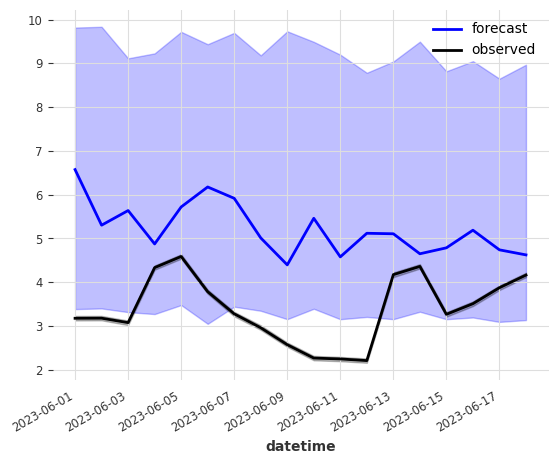

In [41]:
plt.clf()
preds = final_model.predict(n=30,
                            past_covariates=covs, 
                            num_samples=500)
preds[:18].plot(color="blue", label="forecast")
validation_set.plot(color="black", label="observed")
plt.show()

In [42]:
preds[:18].pd_dataframe().to_csv("predicted_direct_example.csv")

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
